loading data
data shapes: (100, 7) (100, 7) (100, 1) (100, 1)
plotting data


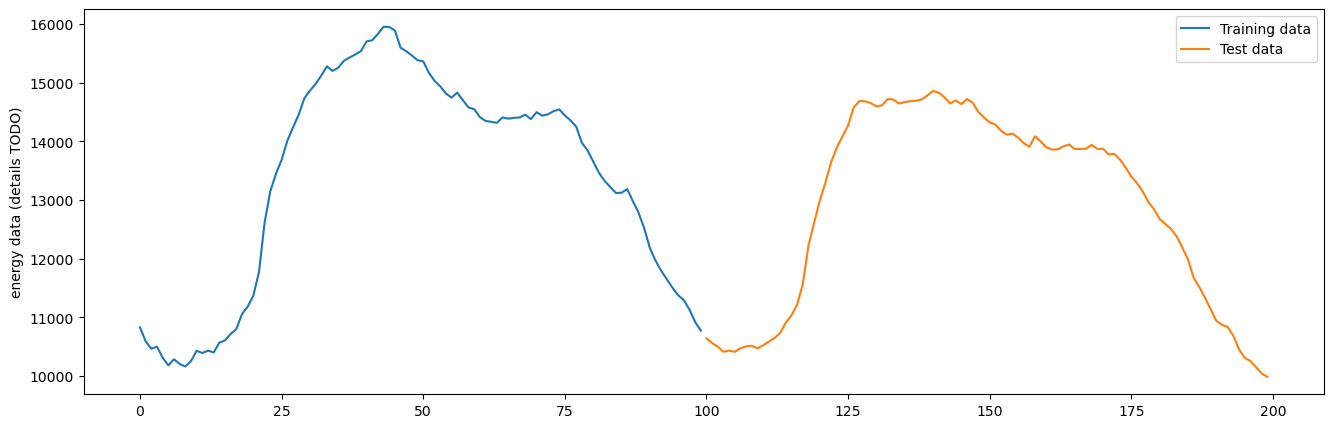

running native methods
running native methods
estimating QR intervals
training base model
running posthoc methods
estimating CP intervals
loaded model successfully
predicting...
plotting native vs posthoc results
plotting native results...


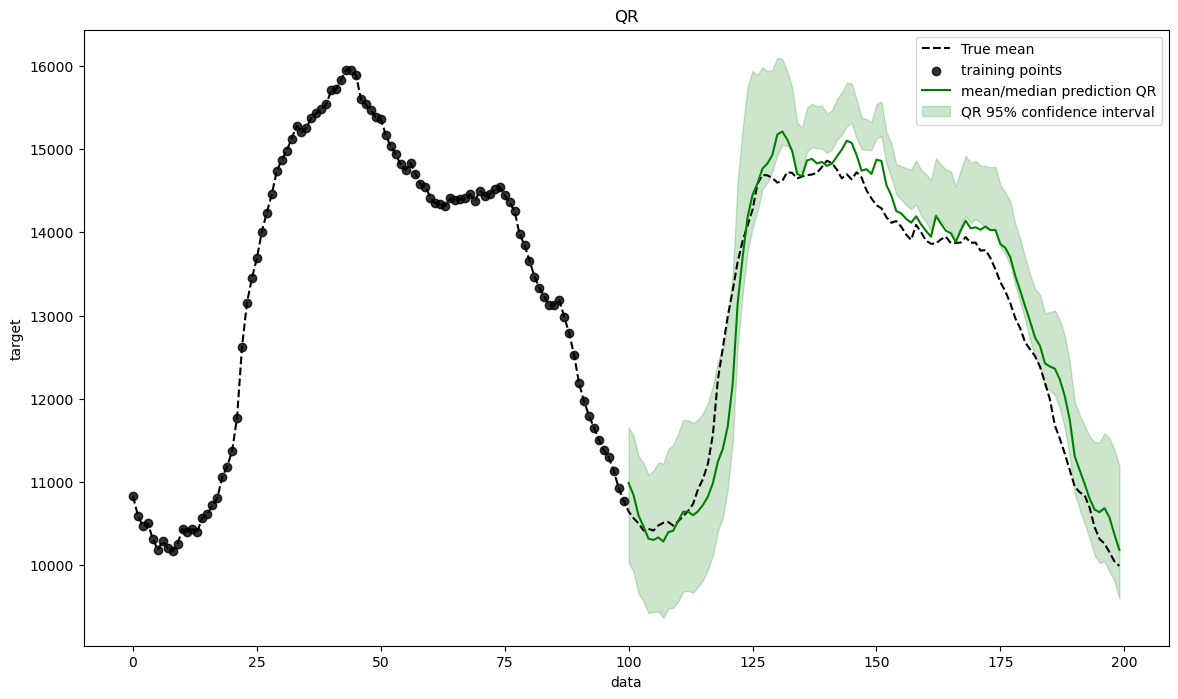

plotting posthoc results...


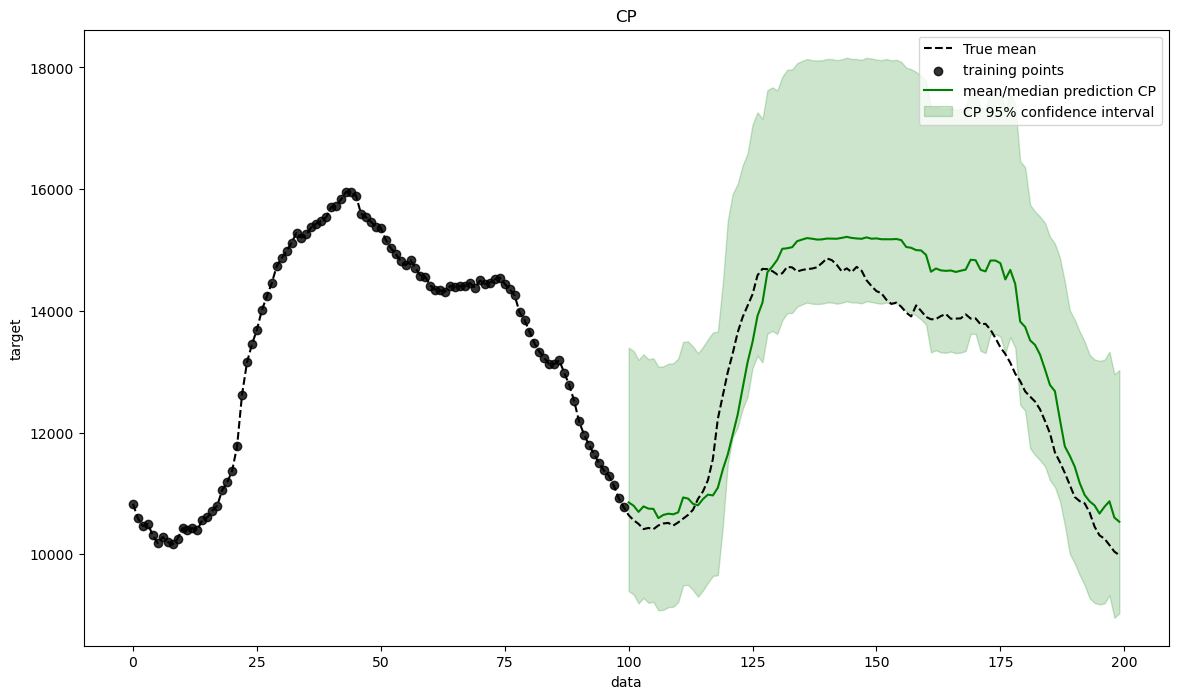

In [1]:
from compare_methods import *

native_results, posthoc_results = compare_methods(GET_DATA_FUNC, TRAIN_BASE_MODEL_FUNC, NATIVE_METHODS, POSTHOC_METHODS, METRICS, should_plot_data=True)

In [2]:
qr_results = native_results['QR']
qr_pred, qr_pis = qr_results
# dis = display

X_train, X_test, y_train, y_test, X, y = [df.to_numpy().squeeze() for df in GET_DATA_FUNC()]

In [3]:
import uncertainty_toolbox as uct


def acc_metrics(y_pred):
    # todo: meaning of std?
    return uct.get_all_accuracy_metrics(y_pred, y_test, verbose=False)


arrs = {
    'qr': qr_pred,
    'shifted': np.concatenate((y_train[-1:], y_test[:-1])),
    'perfect': y_test,
    'zero': np.zeros_like(y_test),
    'mean': np.repeat(np.mean(y_train), y_test.size),
}
metrics = {name: acc_metrics(arr) for name, arr in arrs.items()}
for name, metric in metrics.items():
    print('\n' + name)
    display(metric)


qr


{'mae': 296.05355910300443,
 'rmse': 387.2503635093589,
 'mdae': 228.63315192340633,
 'marpd': 2.3356627820545035,
 'r2': 0.9449593523402956,
 'corr': 0.9781447696320075}


shifted


{'mae': 111.5275,
 'rmse': 151.75218491013564,
 'mdae': 84.0,
 'marpd': 0.8932616199677408,
 'r2': 0.991547799847972,
 'corr': 0.9957811691773708}


perfect


{'mae': 0.0, 'rmse': 0.0, 'mdae': 0.0, 'marpd': 0.0, 'r2': 1.0, 'corr': 1.0}


zero


{'mae': 12903.4825,
 'rmse': 13008.629604732583,
 'mdae': 13735.25,
 'marpd': 200.0,
 'r2': -61.110205151049335,
 'corr': nan}


mean


{'mae': 1432.3275,
 'rmse': 1711.2224677752306,
 'mdae': 1293.4375,
 'marpd': 11.32978353073758,
 'r2': -0.07476326712561998,
 'corr': nan}

In [4]:
import sklearn.metrics as skmet


def all_metrics(pred_mean, pred_std):
    return uct.get_all_metrics(pred_mean, pred_std, y_test)


qr_quants = {
    0.05: qr_pis[:, 0],
    0.50: qr_pred,
    0.95: qr_pis[:, 0],
}

pinball_losses = {
    quant: skmet.mean_pinball_loss(y_test, quant_pred, alpha=quant)
    for quant, quant_pred in qr_quants.items()
}
print('pinball losses per alpha:', pinball_losses)

# todo: correct?
qr_std = qr_pis[:, 1] - qr_pis[:, 0]

mets = all_metrics(qr_pred, qr_std)
# print(mets)

pinball losses per alpha: {0.05: 196.13405653081966, 0.5: 148.02677955150222, 0.95: 308.6634084745599}
 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.11it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.09it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           296.054
  RMSE          387.250
  MDAE          228.633
  MARPD         2.336
  R2            0.945
  Correlation   0.978
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.272
  Mean-absolute Calibration Error       0.245
  Miscalibration Area                   0.247
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.304
     Group Size: 0.56 -- Calibration Error: 0.273
     Group Size: 1.00 -- Calibration Error: 0.245
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.366
     Group Size: 0.56 -- Calibration Error: 0.305
     Group Size: 1.00 -- Calibration Error: 0.272
==========

In [18]:
from mapie_plot_ts_tutorial import (
    estimate_prediction_intervals_enbpi_nopfit_all_quantiles,
    estimate_pred_interals_no_pfit_enbpi,
    plot_prediction_intervals_all_quantiles,
    train_base_model,
)

from mapie.regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap

# plot_data(X_train, X_test, y_train, y_test)

model_params_choices = {
    "max_depth": randint(2, 30),
    "n_estimators": randint(10, 100),
}
model = train_base_model(
    RandomForestRegressor,
    model_params_choices=model_params_choices,
    X_train=X_train,
    y_train=y_train,
    load_trained_model=True,
)

gap = 1
skip_base_training = True
skip_adaptation = True

cv_mapie_ts = BlockBootstrap(
    n_resamplings=10, n_blocks=10, overlapping=False, random_state=59
)


mapie_enbpi = MapieTimeSeriesRegressor(
    model, method="enbpi", cv=cv_mapie_ts, agg_function="mean", n_jobs=-1
)

print('fitting...')
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)
print('done')

fitting...


In [25]:
def display_all(*args):
    for arg in args:
        display(arg)

print("predicting...")



alpha = np.linspace(0.01, 0.99, num=99, endpoint=True)
assert alpha[1] - alpha[0] == 0.01

y_pred_enbpi_no_pfit, y_pis_enbpi_no_pfit = mapie_enbpi.predict(
    X_test,
    alpha=alpha,
    ensemble=True,
    optimize_beta=False,
    allow_infinite_bounds=True,
)
y_pred, y_pis = y_pred_enbpi_no_pfit, y_pis_enbpi_no_pfit.squeeze()

display_all(y_pred.shape, y_pis.shape)
print('done')

predicting...


(100,)

(100, 2, 99)

done


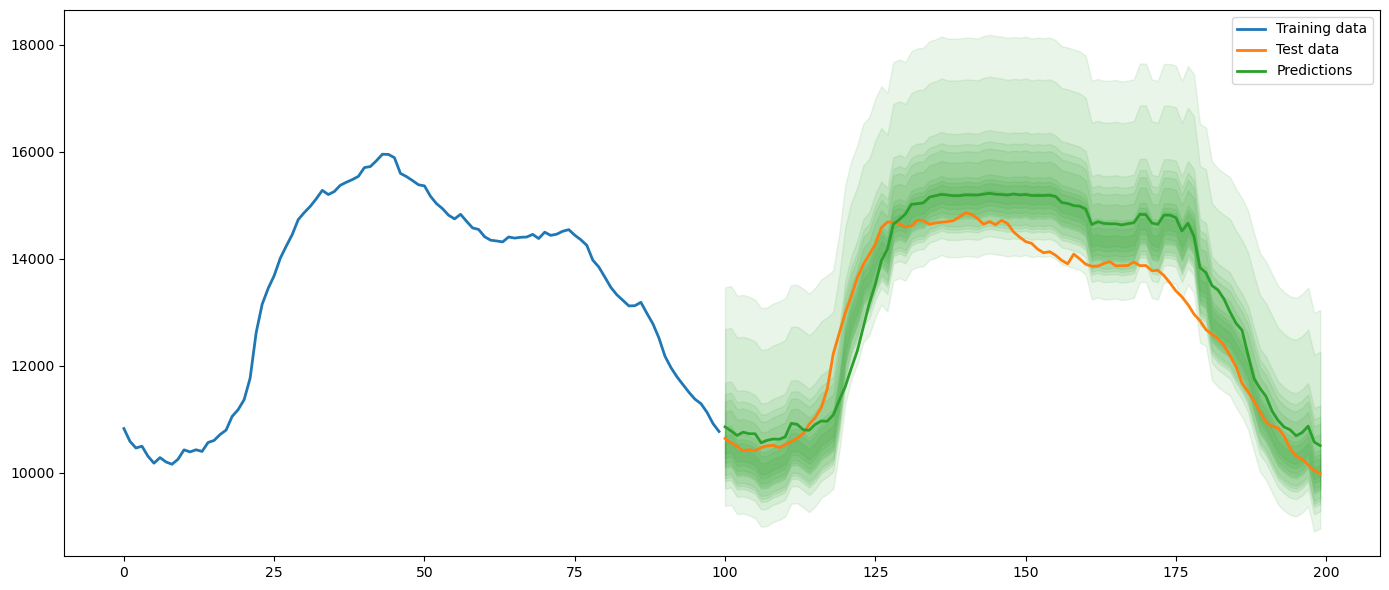

In [118]:
# def plot_prediction_intervals_all_quantiles(y_train, y_test, y_pred, y_pis):
    # coverage, width, cwc = compute_scores(y_pis, y_test, eta=10)

fig, ax = plt.subplots(figsize=(14, 6))

x_plot_test = np.arange(y_test.size) + y_train.size

# ax.set_ylabel("Hourly demand (GW)")
ax.plot(y_train, lw=2, label="Training data", c="C0")
ax.plot(x_plot_test, y_test, lw=2, label="Test data", c="C1")


ax.plot(x_plot_test, y_pred, lw=2, c="C2", label="Predictions")
num_quantiles = y_pis[0,0,:].size
quantile_range = range(0, num_quantiles, 10)
for quantile in quantile_range:
    ax.fill_between(
        x_plot_test,
        y_pis[:, 0, quantile],
        y_pis[:, 1, quantile],
        color="C2",
        alpha=1/len(quantile_range),
        # label="Prediction intervals",
    )
# title = f"EnbPI, {w} update of residuals. "
# # title += f"Coverage:{coverage:.3f} and " f"Width:{width:.3f}"
# ax.set_title(title)
ax.legend()
fig.tight_layout()
plt.show()


# plot_prediction_intervals_all_quantiles(
#     y_train, y_test, y_pred, y_pis
# )

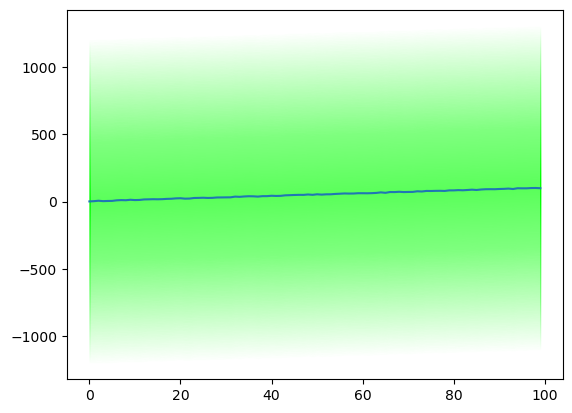

In [112]:
num_quantiles = 100
quantile_dist = 12
n = 100
dist = 5
jitter = 5
jitter_y = jitter

fig, ax = plt.subplots()

myx = np.arange(n)
myy = myx + jitter_y * np.random.rand(n)
ax.plot(myx, myy)

upper = myy.reshape(-1, 1) + (dist + jitter * np.random.rand(n, num_quantiles))
lower = myy.reshape(-1, 1) - (dist + jitter * np.random.rand(n, num_quantiles))

for shift in range(num_quantiles):
    lower[:, shift] -= quantile_dist * shift
    upper[:, shift] += quantile_dist * shift

for cur_lower, cur_upper in zip(lower.T, upper.T):
    ax.fill_between(myx, cur_lower, cur_upper, color=(0,1,0), alpha=0.008, label="Prediction intervals")